# Global sensitivity analysis. A flood case study.

In [1]:
## Computer experiments course.
## O. Roustant (INSA Toulouse), with contributions from B. Iooss (EDF & IMT)

We consider a simplified first model simulating flooding events.
The model has $8$ input random variables, viewed as random variables:

* $X_{1} = Q$, Maximal annual flowrate (m$^3$/s), Gumbel ${\mathcal G}(1013, 558)$ truncated on $[500 , 3000 ]$
* $X_{2}=K_s$, Strickler coefficient, Normal ${\mathcal N}(30, 8^2)$ truncated on $[15 , +\infty [$
* $X_{3} = Z_v$, River downstream level (m), Triangular ${\mathcal T}(49, 51)$ 
* $X_{4} = Z_m$, River upstream level (m), Triangular  ${\mathcal T}(54, 56)$
* $X_{5} = H_d$, Dyke height (m),  Uniform ${\mathcal U}[7, 9]$ 
* $X_{6} = C_b$, Bank level (m), Triangular ${\mathcal T}(55, 56)$
* $X_{7} = L$, River stretch (m), Triangular ${\mathcal T}(4990, 5010)$
* $X_{8} = B$, River width (m), Triangular ${\mathcal T}(295, 305)$

We consider two variables of interest. First, the maximal annual overflow $S$ (in meters), obtained from simplified hydro-dynamical equations of Saint-Venant:
\begin{equation}
S = \left(\frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} + Z_v - H_d - C_b \,.
\end{equation}
Secondly, the cost (in million euros) of the damage on the dyke $Y$, depending on $S$, written as:
\begin{equation}
Y = 1_{S>0} +  \left[0.2 + 0.8\left( 1-\exp^{-\frac{1000}{S^4}}\right) \right] 1_{S \leq 0} + \frac{1}{20}\left(H_d 1_{H_d>8} + 8 1_{H_d \leq 8} \right) \,,
\end{equation}
where $1_{A}(x)$ is the indicator function which is equal to 1 for $x \in A$ and 0 otherwise.
The aim is to perform a global sensitivity analysis for $S$ and $Y$. In particular, we would like to detect the non-essential input variables and the active subspaces.


In [1]:
# Input names
floodInputNames <- c("Q", "Ks", "Zv", "Zm", "Hd", "Cb", "L", "B")
floodOutputNames <- c("Subverse", "Cost")

# Flood model
flood <- function(X, ans = 0){ 
    # ans = 1 gives Overflow output; ans = 2 gives Cost output; ans=0 gives both
    mat <- as.matrix(X, ncol = 8)
    if (ans == 0) {
        output <- matrix(NA, nrow(mat), 2)
    } else { 
        output <- rep(NA, nrow(mat))
    }
    for (i in 1:nrow(mat)){
        H <- (mat[i, 1] / (mat[i, 2] * mat[i, 8] * sqrt((mat[i, 4] - mat[i, 3]) / mat[i, 7])))^0.6
        S <- mat[i, 3] + H - mat[i, 5] - mat[i, 6] 
    if (S > 0){ 
        Cp <- 1
    } else { 
        Cp <- 0.2 + 0.8 * (1 - exp(- 1000 / S^4))
    }
    if (mat[i, 5] > 8){
        Cp <- Cp + mat[i, 5] / 20 
    } else { 
        Cp = Cp + 8 / 20
    }
    if (ans == 0){
        output[i, 1] <- S ;
        output[i, 2] <- Cp ;
    }
    if (ans == 1) output[i] <- S
    if (ans == 2) output[i] <- Cp 
    }
    return(output)
}

In [3]:
install.packages('sensitivity')

installation des dépendances ‘modeltools’, ‘dtw’, ‘clue’, ‘flexclust’, ‘Matrix’, ‘RSpectra’, ‘RcppParallel’, ‘shinyjs’, ‘RcppThread’, ‘numbers’, ‘dtwclust’


Warning message in install.packages("sensitivity"):
“installation of package ‘dtw’ had non-zero exit status”
Warning message in install.packages("sensitivity"):
“installation of package ‘clue’ had non-zero exit status”
Warning message in install.packages("sensitivity"):
“installation of package ‘Matrix’ had non-zero exit status”
Warning message in install.packages("sensitivity"):
“installation of package ‘RcppParallel’ had non-zero exit status”
Warning message in install.packages("sensitivity"):
“installation of package ‘RcppThread’ had non-zero exit status”
Warning message in install.packages("sensitivity"):
“installation of package ‘flexclust’ had non-zero exit status”
Warning message in install.packages("sensitivity"):
“installation of package ‘RSpectra’ had non-zero exit status”
Warning message in install.packages("sensitivity

In [4]:
install.packages('triangle')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Function for flood model inputs sampling
library(sensitivity) # (truncated) Gumbel law and truncated Normal law
library(triangle) # Triangular law

floodSample <- function(size){
    X <- matrix(NA, size, 8)
    X[, 1] <- rgumbel.trunc(size, loc = 1013, scale = 558, min = 500, max = 3000)
    X[, 2] <- rnorm.trunc(size, mean = 30, sd = 8, min = 15)
    X[, 3] <- rtriangle(size, a = 49, b = 51)
    X[, 4] <- rtriangle(size, a = 54, b = 56)
    X[, 5] <- runif(size, min = 7, max = 9)
    X[, 6] <- rtriangle(size, a = 55, b = 56)
    X[, 7] <- rtriangle(size, a = 4990, b = 5010)
    X[, 8] <- rtriangle(size, a = 295, b = 305)
    return(X)
}

ERROR: Error in library(sensitivity): aucun package nommé ‘sensitivity’ n'est trouvé


## Starter

# Questions

First select the output 1 (Subverse). The aim is to perform a global sensitivity analysis (GSA) in order the discover what are the most influential inputs, the unessential ones, to visualize the input-output relationship and to quantify the importance of the inputs on the outputs. For the sake of reproducibility, fix the seed to 0 each time a random sampling is done (in R: set.seed(0)).

## GSA with an unlimited budget
We first consider the case of an unlimited budget. Thus we choose a large sample size $N = 5\,000$ (for instance). 

1. Simulate a sample of size $N$ of the inputs by Monte Carlo and compute the corresponding output (use the R functions "floodSample" and "flood"). Store the sample in a matrix called $X$, and the output values in a vector called $Y$. Plot the output versus the inputs. Comment the results: what is the form of the input-output relationship?  


2. Estimate the global mean. Estimate the main effects with local polynomial regression (use the R function "loess"). Adapt the previous matrix of graphs to superimpose the main effects.  


3. Estimate the Sobol indices with the R function "sobolJansen" (package "sensitivity"). Plot the results and comment them: what are the most influential variables? Are there interactions? Between which variables?


## GSA with a limited budget
Now we want to retrieve these results with a limited budget, say $n = 10d$ where $d = 8$ is the inputs dimension.
To reach that goal, we do three steps: (a) create a design of experiments, (b) build a Gaussian process metamodel, (c) perform the GSA on the metamodel. We adopt a "goal-oriented" strategy, meaning that we aim the metamodel to be accurate when the probability distribution of the inputs is taken into account.

4. We first choose carefully a design of experiments of size $n$. 
a) What are the main drawbacks of Monte Carlo sampling with a small sample size? Explain why it is not possible to use a full factorial design here ; even if it were possible, recall why it is not a good idea, in relation to question 3.   
b) To overcome these drawbacks, create a space-filling design as a Sobol sequence. This first design is well suited for uniform distributions. Use the quantile transformation to deduce a design of experiments, called $Xtrain$, such that marginal distribution of the inputs is correct; for that create a function called "floodQuantile" by adapting the function "floodSample" above. Visualize the result with a scatterplot (with histograms on the diagonal) and compare (visually) with Monte Carlo sampling (function "floodSample").  

5. Compute the output values corresponding to $Xtrain$ and store them in a vector called $Ytrain$. Estimate a Gaussian process metamodel (or kriging model) with function "km" (R package "DiceKriging"). What is the kernel used by default? Comment briefly the model validity by using the diagnostics proposed in function "plot". Compute its performance on the sample $X$, used as a test set: plot the predicted values versus the true ones (stored in $Y$). Compute the $Q^2$ criterion defined by 
$$Q^2(Y, \hat{Y}) = 1 - \frac{\Vert Y - \hat{Y} \Vert^2}{\Vert Y - \bar{Y} \Vert^2} $$
where the norm is the Euclidean norm, and $\bar{Y}$ is the mean of $Y$. Thus $Q^2$ compares the performance of the predictions $\hat{Y}$ compared to what would be predicted by the constant prediction equal to the mean.

6. Compare the performance of the GP metamodel with a naive linear model (first-order polynomial). When the output is the cost, add $H_d^2$ to the covariates of this linear model (explain why it is reasonable). For that, plot the predictions versus the true values, and compute the $Q^2$ criterion as well.

7. Perform a GSA on the mean of the GP metamodel (kriging mean) by doing questions 1-3 for it. Compare these results to the unlimited budget case.

## Metamodeling improvements and physics-informed Gaussian process

To improve the metamodeling step, we bring some information contained in the equations defining the subverse and the cost.

8. Consider the output "subverse". Play with function 'km' in order to add a linear trend to the GP model. Check that this model outperforms the basic GP, by plotting the prediction on the test set (here $X$) versus the true value, and computing the $Q^2$ criterion. Redo question 7 for this model. Comment?

9. Knowing the equation of the ouput "cost", we see that a suitable GP should have the form 
$$Y(S, H_d) = Y_1(S) + Y_2(H_d)$$
Assuming that $Y_1, Y_2$ are independent Gaussian processes with kernels $k_1, k_2$, what form should have the kernel of $Y$? Estimate this new GP with function "kmAdditive", from the R package fanovaGraph, still using $Xtrain$ as a desing of experiments. Check that this model outperforms the basic GP. Compare also with a GP depending on $S$ and $H_d$. However, explain why it seems difficult to use this approach for global sensitivity analysis with respect to the original variables.

## At least one theoretical computation

10. For the output "S", compute theoretically the main effect with respect to the variable $H_d$. Compare with 3)a). Same question for $C_b$.


In [4]:
myOutput <- 1  # 1 for subverse, 2 for cost

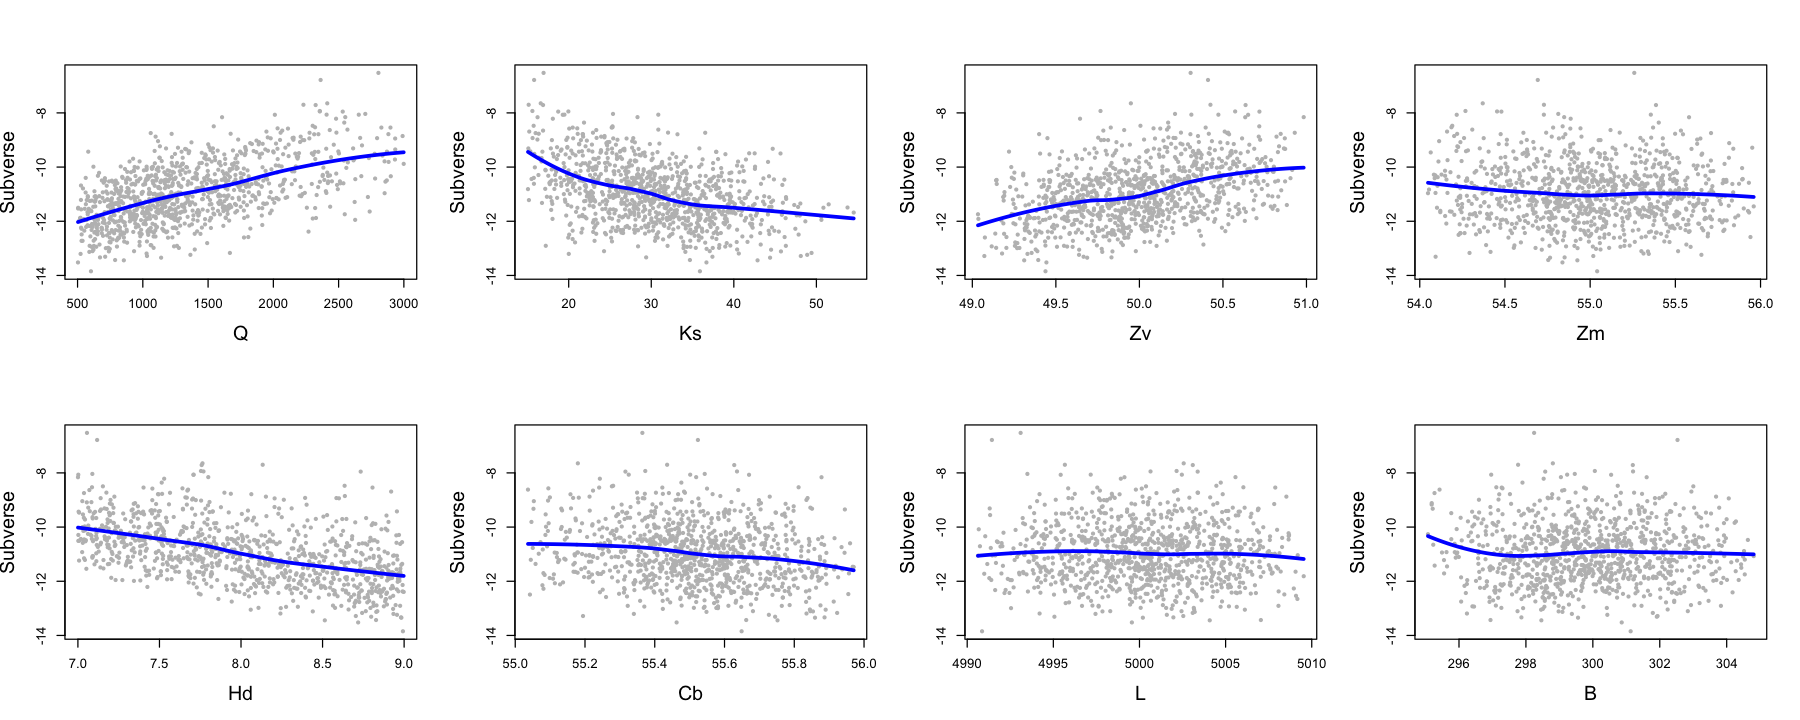

In [5]:
# Help for questions 1 and 2

N <- 1000  # to be upgraded
set.seed(0); X <- floodSample(N); colnames(X) <- floodInputNames
Y <- flood(X, ans = myOutput)
# Ymean <- ...
par(mfrow = c(2, 4))
options(repr.plot.width = 15, repr.plot.height = 6)

# the next lines must be slightly adapted, there are not exactly suited to represent the main effects
for (i in 1:8){
    plot(Y ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames[myOutput], 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- loess(Y ~ X[, i])
    t <- seq(from = min(X[, i]), to = max(X[, i]), length = 100)
    lines(t, predict(ss, t), col = "blue", lwd = 3)
}


In [ ]:
# Help for question 3

library(boot)
# we use a pick-freeze formula (Sobol Jansen), which requires two samples
X1 <- floodSample(N)
X2 <- floodSample(N)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis
## to be completed 
SAresult <- soboljansen(model = ..., X1, X2, nboot = 100, ans = myOutput)
totalIndex <- SAresult$T$original; names(totalIndex) <- floodInputNames
sobolIndex <- SAresult$S$original; names(sobolIndex) <- floodInputNames

library(ggplot2)
ggplot(SAresult)

In [ ]:
# Help for question 4

library(DiceDesign)
library(randtoolbox)
?sobol  # What kind of scrambling is the best here? See also rss2d

# skeleton of function floodQuantile
floodQuantile <- function(M){
  X <- matrix(NA, nrow = nrow(M), ncol = ncol(M))
  X[, 1] <- ...
  ...
  X[, 8] <- ...
  return(X)
}

# scatterplot with histograms on the diagonal (from the helppage of pairs)
panel.hist <- function(x, ...)
{
  usr <- par("usr")
  par(usr = c(usr[1:2], 0, 1.5) )
  h <- hist(x, plot = FALSE)
  breaks <- h$breaks; nB <- length(breaks)
  y <- h$counts; y <- y/max(y)
  rect(breaks[-nB], 0, breaks[-1], y, col = "cyan", ...)
}
pairs(Xtrain, diag.panel = panel.hist)

In [ ]:
# help for question 5
library(DiceKriging)
?km  

# For function km, a data.frame is required for argument design. Use:
train <- data.frame(Xtrain); names(train) <- floodInputNames
# important : use multistart (possibility of parallel computations)
km(~ 1, design = train, response = Y, multistart = 5)


# a code for the Q2 criterion is the following
Q2 <- function(y, yhat){
  1 - sum((y - yhat)^2) / sum((y - mean(y))^2)
}

# in the plot Yhat versus Y, add the straight line y = x:
?abline  

In [ ]:
# Help for question 6
?lm
# Pour lm, it is recommended to use a data.frame pour data, 
# containing both Xtrain (train more precisely, cf. question 5) and Ytrain
data = data.frame(y = Ytrain, train)

# for prediction on a new dataset, both lm and km want data.frame 
# with the SAME input names as Xtrain (and not only matrices). 
# Thus, use
newdata <- data.frame(X)
names(newdata) <- floodInputNames


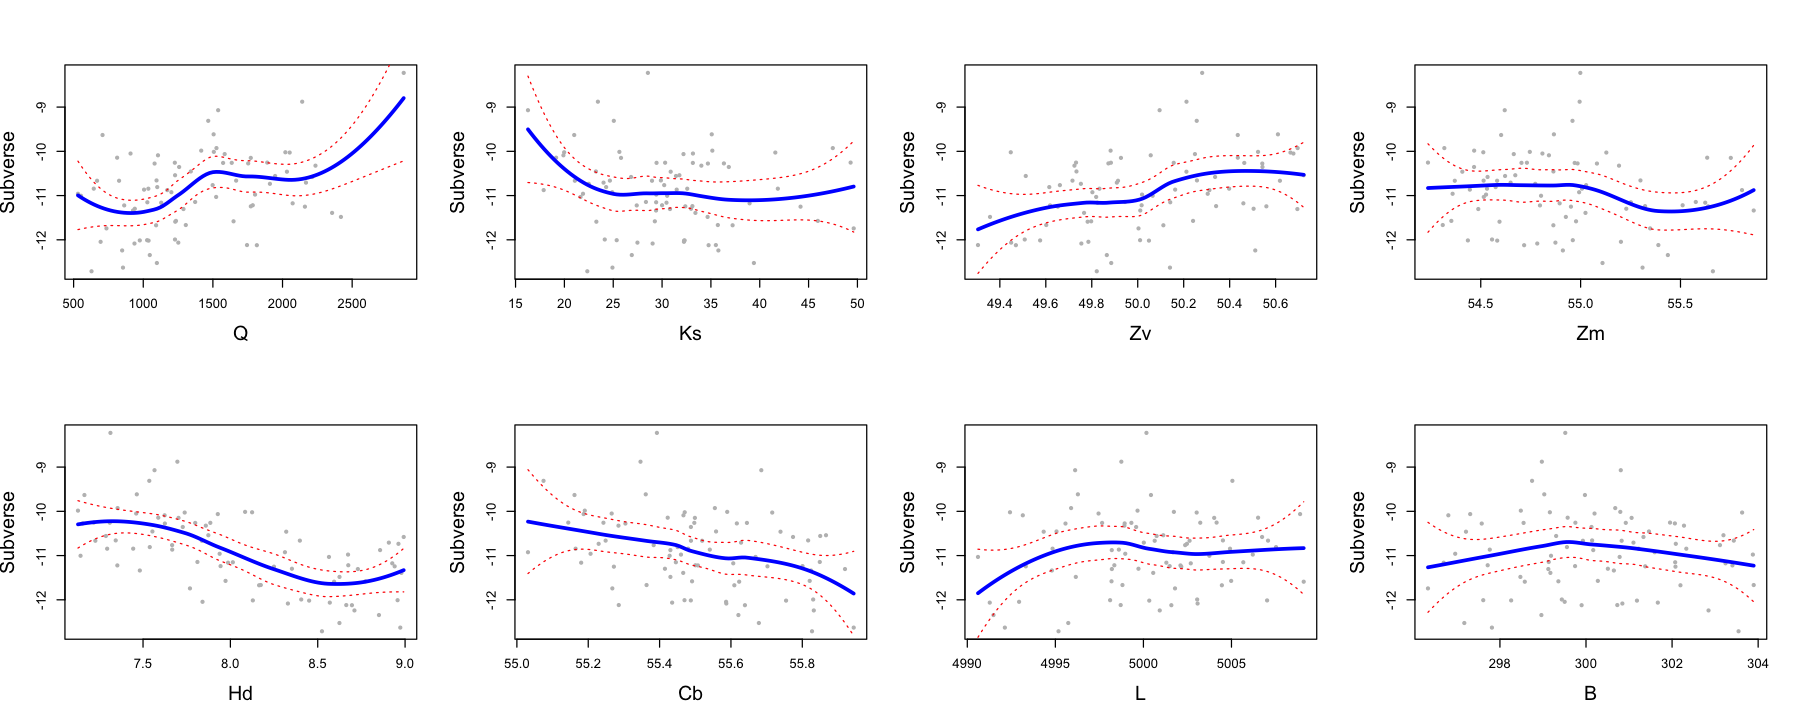

In [6]:
# help for question 7

# to plot the main effects, it can be useful to add the confidence intervals, because n is small.
# here is the code of question 2, for n = 80, with confidence intervals. To be adapted to your purpose !!
n <- 80  
set.seed(0); X <- floodSample(n); colnames(X) <- floodInputNames
Y <- flood(X, ans = myOutput)

par(mfrow = c(2, 4))
for (i in 1:8){
    plot(Y ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames[myOutput], 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- loess(Y ~ X[, i], se = TRUE)
    t <- seq(from = min(X[, i]), to = max(X[, i]), length = 100)
    predss <- predict(ss, t, se = TRUE)
    lines(t, predss$fit, col = "blue", lwd = 3)
    lines(t, predss$fit + 2 * predss$se, col = "red", lty = "dotted")
    lines(t, predss$fit - 2 * predss$se, col = "red", lty = "dotted")
}

# Use the following wraper, where m is the ouput of function km: m <- km(...), and Xnew is a test set.
krigingMean <- function(Xnew, m){
  pred <- predict(m, Xnew, "UK", se.compute = FALSE, checkNames = FALSE)
  return(as.numeric(pred$mean))  
}

In [ ]:
# help for question 9
library(fanovaGraph)
?kmAdditive
# A clique is a complete subgraph, i.e. where all vertices are connected.
# Here the vertices [sommets] are variables; an edge [arêtes] exists if there is an interaction 
# involving at least the two variables corresponding to two vertices.
# Thus a clique correspond to a group of variables that interact together and, more importantly, 
# variables belonging to different cliques should not have any interaction at any order (alone or with other variables).
# In brief, if a function is additive with respect to groups of variables, the cliques correspond to the groups.
# For instance, in the Ishigami function, there are two cliques : {1, 3} and {2}.

# Similarly to question 7, here is a wraper for sensitivity analysis
krigingMeanAdditive <- function(newdata, design, response, gp, cliques){
    predictAdditive(newdata = newdata, x = design, y = response, parameter = gp, cl = cliques)$mean
}
  